**Goal**: sample the warnings to manually inspect and create plots based on those.

In [62]:
import project_path
from rdlib import *  # this imports the base libraries

import glob
from typing import Dict, List
import re
import yaml
import json
from tqdm import tqdm
from sarif import loader
import shutil
import random

from IPython.display import display

# DATA
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_11-53-38/"
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_14-02-32/"
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_15-14-24/"  # FULLY INSPECTED - ANN 1
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-14_18-10-35/"  # PARTIALLY - ANN 2
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-15_19-14-06" # PARTIALLY - ANN 1
SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-18_17-17-54"  # FINAL MODELING
MAIN_FOLDER_DATA = "../data/datasets/exp_v08/files_selected"
PATH_LINTQ_SARIF = os.path.join(SARIF_FOLDER, "data.sarif")
DIR_DATASET_QISKIT = '../data/datasets/exp_v08'
PATH_LINTQ_ANNOTATION = os.path.join(SARIF_FOLDER, "Annotation_03_data_sample_fixed_10.csv")
PATH_REAL_BUGS = "../bug_reports/true_positives_found/LintQ Annotation 09-2023 - Real bugs.csv"

LOG_FILE_QUERIES = os.path.join(SARIF_FOLDER, 'log.txt')
LOG_FILE_DB_CREATION = '../data/datasets/exp_v08/log_codeql.txt'

# IMAGES
OUTPUT_FOLDER = "paper_figures"
import matplotlib.colors as mcolors
THEME_COLOR_LIGHT_HEX = '#FF5733'
THEME_COLOR_FULL_HEX = '#33FF57'
THEME_COLOR_ACCENT_HEX = '#3366FF'
THEME_COLOR_LIGHT_RGB = mcolors.hex2color(THEME_COLOR_LIGHT_HEX)
THEME_COLOR_FULL_RGB = mcolors.hex2color(THEME_COLOR_FULL_HEX)
THEME_COLOR_ACCENT_RGB = mcolors.hex2color(THEME_COLOR_ACCENT_HEX)

# SAMPLING
FIXED_SAMPLE_SIZE = 10
CONFIDENCE_LEVEL = .90
MARGIN_ERROR = .10
RND_SEED = 42

# PRESENTATION PARAMETERS
LINTQ_CHECKER_TERM = "Analysis"

# RULES
NAME_MAPPING = {
    # measurement
    # ---
    'ql-double-measurement': 'DoubleMeas',
    'DoubleMeasurement.ql': 'DoubleMeas',
    # ---
    'ql-operation-after-measurement': 'OpAfterMeas',
    'OpAfterMeasurement.ql': 'OpAfterMeas',
    # ---
    'ql-measure-all-abuse': 'MeasAllAbuse',
    'MeasureAll.ql': 'MeasAllAbuse',
    # ---
    'ql-constant-classic-bit': 'ConstClasBit',
    'ConstantClassicBit.ql': 'ConstClasBit',
    # conditional control flow
    # ---
    'ql-conditional-without-measurement': 'CondWoMeas',
    'ConditionalGateWithoutMeas.ql': 'CondWoMeas',

    # composition
    # # ---
    # 'ql-incompatible-composition': 'IncompCompose',
    # 'IncompatibleComposition.ql': 'IncompCompose',
    # # ---
    # 'ql-ungoverned-composition': 'UngovCompose',
    # 'UngovernedComposition.ql': 'UngovCompose',

    # resources
    # ---
    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'UnmeasurableQubits.ql': 'InsuffClasReg',
    # ---
    'ql-oversized-circuit': 'OversizedCircuit',
    'OversizedCircuit.ql': 'OversizedCircuit',
    # # ---
    # 'ql-superfluous-op': 'SuperfluousOp',
    # 'SuperfluousOp.ql': 'SuperfluousOp',


    # api constraints
    # ---
    'ql-op-after-optimization': 'OpAfterTransp',
    'OpAfterOptimization.ql': 'OpAfterTransp',
    # ---
    'ql-ghost-composition': 'GhostCompose',
    'GhostComposition.ql': 'GhostCompose',
}

RULE_NAME_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.startswith('ql-')
}
FILE_NAME_RULE_MAPPING = {
    k: v for k, v in NAME_MAPPING.items() if k.endswith('.ql')
}


# Abstraction
DETECTORS_FOLDER = '../qlint/codeql/src'
ABSTRACTION_FOLDER = '../qlint/codeql/lib/qiskit'

# Abstractions to consider
ABSTRACTIONS = [
    "QuantumCircuit",
    "RegisterV2",
    "QuantumRegisterV2",
    "ClassicalRegisterV2",
    "QubitUse",
    "QuantumOperator",
    "Measurement",
    "Subcircuit",
    "ComposeCall",
    "TranspileCall"
]

In [43]:
def get_results_from_sarif_path(sarif_path: str) -> Dict[str, Any]:
    """Extract the results from the sarif file as json."""
    with open(sarif_path, "r") as f:
        sarif_data = json.load(f)
    all_results = []
    n_runs = len(sarif_data['runs'])
    for i in range(n_runs):
        sarif_results = sarif_data["runs"][i]["results"]
        all_results.extend(sarif_results)
    return all_results


def get_df_from_sarif(sarif_results: List[Dict[str, Any]]):
    """Create a dataset from sarif results."""
    def process(record: Dict[str, Any]):
        """Parse some key info from the record."""
        region = record["locations"][0]["physicalLocation"].get("region", None)
        line, col = None, None
        if region:
            line = region.get("startLine", None)
            col = region.get("startColumn", None)
        return {
            "rule_id": record["ruleId"],
            "message": record["message"]["text"],
            "file": record["locations"][0]["physicalLocation"]["artifactLocation"]["uri"],
            "line": line,
            "col": col,
        }

    processed_results = [
        process(result)
        for result in sarif_results
    ]

    df_results = pd.DataFrame.from_records(processed_results)
    return df_results


def compute_representative_sample_size(
        population_size, margin_error=.05,confidence_level=.95,sigma=1/2):
    """Calculate sample size for a representative sample of the population.
    
    Credits: https://github.com/shawnohare/samplesize/blob/master/samplesize.py
    """

    alpha = 1 - (confidence_level)
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    numerator = z**2 * sigma**2 * (N / (N-1))
    denom = M**2 + ((z**2 * sigma**2)/(N-1))
    return int(numerator/denom + 0.5)

res = compute_representative_sample_size(10000, margin_error=.05,confidence_level=.95,sigma=1/2)
assert res == 370

def get_file_extension_dictionary(dir: str) -> dict:
    """Get a dictionary {filename: its extension, etc.} form a directory."""
    file_extensions = {}
    for file in os.listdir(dir):
        base_name = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        file_extensions[base_name] = extension
    return file_extensions


def count_files(folder: str, allowed_formats: List[str] = [".py", "ipynb"]):
    """Count how many files with the given extension are in the target folder."""
    files_extension = get_file_extension_dictionary(folder)
    return sum([
        1
        for file, extension in files_extension.items()
        if extension in allowed_formats
    ])
    

def compute_warnings_table(
        df_results: pd.DataFrame, 
        rule_name_mapping: Dict[str, str],
        total_files_in_dataset: int,
        rule_term: str):
    """Compute the table in latex with number and percentage of warnings."""
    # compute: total sum of warnings
    df_abs = df_results.copy()
    df_abs = df_abs[["rule_id", "file"]]
    df_abs = df_abs.groupby("rule_id").count()
    df_abs = df_abs.reset_index(drop=False)
    df_abs = df_abs.rename(columns={"file": "tot_warnings"})

    # compute: files affected
    df = df_results.copy()
    df = df[["rule_id", "file"]]
    df = df.drop_duplicates()  # << difference
    df = df.groupby("rule_id").count()
    df = df.reset_index(drop=False)
    df = df.rename(columns={"file": "n_files_affected"})

    df = df.merge(df_abs, on="rule_id", how="left")
    if rule_name_mapping is not None:
        # add all the rules that are not in the dataframe with 0 warnings
        for rule in list(rule_name_mapping.keys()):
            if rule not in df['rule_id'].unique():
                print(f"WARN: no warnings for rule {rule}. Adding a 0 value.")
                df = pd.concat([df, pd.DataFrame([{
                    'rule_id': rule, 
                    'tot_warnings': 0,
                    'n_files_affected': 0}])], ignore_index=True)
        # keep only rules that are in the mapping
        rules_not_in_mapping = \
            set(df['rule_id'].unique()) - set(rule_name_mapping.keys())
        if len(rules_not_in_mapping) > 0:
            print("WARN: some rules are not in the mapping. Discarding them.")
            print(rules_not_in_mapping)
            df = df[df['rule_id'].isin(rule_name_mapping.keys())]
        # rename column rules with mapping
        df['rule_id'] = df['rule_id'].apply(
            lambda e: rule_name_mapping[e] 
            if e in rule_name_mapping.keys() else e)

    # rename column
    df['perc_of_affected_files'] = df['n_files_affected'].apply(
        lambda e: (int(e) / total_files_in_dataset) * 100)
    

    # compute average and median of the perc_of_affected_files
    avg = df['perc_of_affected_files'].mean()
    median = df['perc_of_affected_files'].median()
    print("\\newcommand{\\avgWarningsPerc}{" + f"{avg:.2f}" + "\\%}")
    print("\\newcommand{\\medianWarningsPerc}{" + f"{median:.2f}" + "\\%}")

    # format as a percentage
    df['perc_of_affected_files'] = df['perc_of_affected_files'].apply(
        lambda e: "{:.2f}%".format(e))
    if rule_name_mapping is not None:
        # sort by canonical order
        categories = [cat for cat in rule_name_mapping.values()]
        df['rule_id'] = pd.Categorical(
            df['rule_id'], categories=categories)
        df = df.sort_values('rule_id')

    # cosmetic renaming
    mapping_column_to_name = {
        "rule_id": f"{rule_term} Name",
        "tot_warnings": "Tot. warnings",
        "perc_of_affected_files": "Files with warning",
    }
    # drop col not in the mapping
    df = df[mapping_column_to_name.keys()]
    df = df.rename(columns=mapping_column_to_name)


    table = df.to_latex(index=False, column_format="lrr")
    # replace % escaping
    table = table.replace("%", "\\%")
    print(table)
    display(df.reset_index(drop=True).head(20))
    return df


# Data Exploration: Statistics

In [44]:
TOTAL_FILES_IN_DATASET = count_files(
    folder=os.path.join(DIR_DATASET_QISKIT, "files_selected"),
    allowed_formats=[".py", "ipynb"]
)
print("\\newcommand{\\nTotalFiles}{" + f"{TOTAL_FILES_IN_DATASET:,}" + "}")

\newcommand{\nTotalFiles}{7,568}


In [45]:
sarif_results_lintq = get_results_from_sarif_path(PATH_LINTQ_SARIF)
df_results_lintq = get_df_from_sarif(sarif_results_lintq)

# keep relevant rule_id in RULE_NAME_MAPPING
df_results_lintq = df_results_lintq[
    df_results_lintq["rule_id"].isin(RULE_NAME_MAPPING.keys())]

df_results_lintq.head()


,rule_id,message,file,line,col
6,ql-ghost-composition,"Ghost composition at location: (222, 1)",error_correction_repetition_code_e94ab1.py,222.0,NaN
7,ql-ghost-composition,"Ghost composition at location: (249, 1)",error_correction_repetition_code_e94ab1.py,249.0,NaN
8,ql-ghost-composition,"Ghost composition at location: (275, 1)",error_correction_repetition_code_e94ab1.py,275.0,NaN
9,ql-ghost-composition,"Ghost composition at location: (303, 1)",error_correction_repetition_code_e94ab1.py,303.0,NaN
10,ql-ghost-composition,"Ghost composition at location: (42, 1)",h2evo_6bb46f.py,42.0,NaN


# Data Exploration: Warning Rate

/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


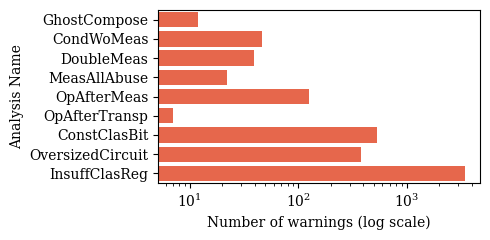

In [46]:
fig, ax = plt.subplots(figsize=(5, 2.5))

sns.countplot(
    data=df_results_lintq,
    color=THEME_COLOR_LIGHT_RGB,
    y="rule_id",
    ax=ax
)
# log scale
ax.set_xscale("log")
ax.set_xlabel("Number of warnings (log scale)")
ax.set_ylabel(LINTQ_CHECKER_TERM + " Name")
# replace the y labels with the RULE_NAME_MAPPING
original_labels = ax.get_yticklabels()
ax.set_yticklabels(
    [RULE_NAME_MAPPING[label.get_text()] for label in original_labels]
)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "EDA_fig_warnings_per_rule.pdf"))

In [47]:
df_warnings_table = compute_warnings_table(
    df_results=df_results_lintq,
    rule_name_mapping=RULE_NAME_MAPPING,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term=LINTQ_CHECKER_TERM
)


\newcommand{\avgWarningsPerc}{2.95\%}
\newcommand{\medianWarningsPerc}{0.36\%}
\begin{tabular}{lrr}
\toprule
Analysis Name & Tot. warnings & Files with warning \\
\midrule
DoubleMeas & 39 & 0.36\% \\
OpAfterMeas & 127 & 0.92\% \\
MeasAllAbuse & 22 & 0.26\% \\
ConstClasBit & 533 & 4.29\% \\
CondWoMeas & 46 & 0.22\% \\
InsuffClasReg & 3489 & 17.35\% \\
OversizedCircuit & 378 & 3.01\% \\
OpAfterTransp & 7 & 0.05\% \\
GhostCompose & 12 & 0.09\% \\
\bottomrule
\end{tabular}



,Analysis Name,Tot. warnings,Files with warning
0,DoubleMeas,39,0.36%
1,OpAfterMeas,127,0.92%
2,MeasAllAbuse,22,0.26%
3,ConstClasBit,533,4.29%
4,CondWoMeas,46,0.22%
5,InsuffClasReg,3489,17.35%
6,OversizedCircuit,378,3.01%
7,OpAfterTransp,7,0.05%
8,GhostCompose,12,0.09%


# Sampling for Inspection

In [36]:
sampled_results = []

# for each rule, sort them alphabetically by filename, 
# then sample 10
all_rules = df_results_lintq["rule_id"].unique()
relevant_rules = [rule for rule in all_rules if rule in RULE_NAME_MAPPING.keys()]

def sample(
        sarif_results: List[Dict[str, Any]],
        relevant_rules: List[str],
        fixed_sample_size=10,
        confidence_level=0.90,
        margin_error=0.10,
        random_seed=42,
        representative_sample_superset=False,):
    """Sample warnings from each rule."""
    sampled_results = []
    for rule in relevant_rules:
        # SET SEED FOR EACH RULE
        random.seed(random_seed)
        warnings_of_i_rule = [
            result 
            for result in sarif_results
            if result["ruleId"] == rule
        ]
        # sort them by filename
        warnings_of_i_rule = sorted(
            warnings_of_i_rule, 
            key=lambda x: x["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
        )
        representative_sample_size = compute_representative_sample_size(
            population_size=len(warnings_of_i_rule), 
            margin_error=margin_error,
            confidence_level=confidence_level
        )
        # consider all 
        sample_i_rule = warnings_of_i_rule
        # get the largest representative sample first
        if representative_sample_size > fixed_sample_size:
            if len(sample_i_rule) > representative_sample_size:
                sample_i_rule = random.sample(sample_i_rule, representative_sample_size)
        
        # condition to trigger the fixed sample size
        if not representative_sample_superset:
            if len(sample_i_rule) > fixed_sample_size:
                sample_i_rule = random.sample(sample_i_rule, fixed_sample_size)
        
        print(f"{len(warnings_of_i_rule)} >> {len(sample_i_rule)}\t ({rule})") 
        sampled_results.extend(sample_i_rule)
    return sampled_results

sarif_sample_fixed = sample(
    sarif_results=sarif_results_lintq,
    relevant_rules=relevant_rules,
    fixed_sample_size=FIXED_SAMPLE_SIZE
)
df_results_sample_fixed = get_df_from_sarif(sarif_sample_fixed)
print(f"FIXED: total sample size: {len(df_results_sample_fixed)}")
print('-' * 80)

sarif_sample_representative = sample(
    sarif_results=sarif_results_lintq,
    relevant_rules=relevant_rules,
    fixed_sample_size=FIXED_SAMPLE_SIZE,
    representative_sample_superset=True,
)
df_results_sample_representative = get_df_from_sarif(sarif_sample_representative)
print(f"REPRESENTATIVE: total sample size: {len(df_results_sample_representative)}")
print('-' * 80)
    


12 >> 10	 (ql-ghost-composition)
46 >> 10	 (ql-conditional-without-measurement)
39 >> 10	 (ql-double-measurement)
22 >> 10	 (ql-measure-all-abuse)
127 >> 10	 (ql-operation-after-measurement)
7 >> 7	 (ql-op-after-optimization)
533 >> 10	 (ql-constant-classic-bit)
378 >> 10	 (ql-oversized-circuit)
3489 >> 10	 (ql-unmeasurable-qubits)
FIXED: total sample size: 87
--------------------------------------------------------------------------------
12 >> 12	 (ql-ghost-composition)
46 >> 28	 (ql-conditional-without-measurement)
39 >> 25	 (ql-double-measurement)
22 >> 17	 (ql-measure-all-abuse)
127 >> 44	 (ql-operation-after-measurement)
7 >> 7	 (ql-op-after-optimization)
533 >> 60	 (ql-constant-classic-bit)
378 >> 58	 (ql-oversized-circuit)
3489 >> 66	 (ql-unmeasurable-qubits)
REPRESENTATIVE: total sample size: 317
--------------------------------------------------------------------------------


In [37]:
# check that all the fixed size records are in the representative one
df_intersection = df_results_sample_fixed.merge(
    df_results_sample_representative,
    how="inner",
    on=["rule_id", "message", "file", "line", "col"],
    suffixes=("_fixed", "_representative")
)
assert len(df_intersection) == len(df_results_sample_fixed)

In [8]:
# export - FIXED, 
to_export = [
    # FIXED SIZE
    {
        'sarif_results': sarif_sample_fixed,
        'prefix': f"data_sample_fixed_{FIXED_SAMPLE_SIZE}"
    },
    # REPRESENTATIVE
    {
        'sarif_results': sarif_sample_representative,
        'prefix': f"data_sample_representative_{FIXED_SAMPLE_SIZE}"
    },
    # DELTA
    {
        'sarif_results': [
            result for result in sarif_sample_representative
            if result not in sarif_sample_fixed],
        'prefix': f"data_sample_delta_{FIXED_SAMPLE_SIZE}"
    }
]

for i_to_export in to_export:
    print("-" * 80)
    new_sarif_i = sarif.copy()
    i_results = i_to_export["sarif_results"]
    i_prefix = i_to_export["prefix"]
    new_sarif_i["runs"][0]["results"] = i_results
    with open(os.path.join(SARIF_FOLDER, f"{i_prefix}.sarif"), "w") as f:
        json.dump(new_sarif_i, f)
    # copy all the files in a dedicated folder
    # create folder in the sarif one with pathlib
    i_subfolder_path = os.path.join(SARIF_FOLDER, i_prefix)
    pathlib.Path(i_subfolder_path).mkdir(parents=True, exist_ok=True)
    # add a gitignore in the subfolder
    with open(os.path.join(i_subfolder_path, ".gitignore"), "w") as f:
        f.write("*")
    i_all_filenames = [
        result["locations"][0]["physicalLocation"]["artifactLocation"]["uri"]
        for result in i_results
    ]
    i_ORIGINAL_filepaths = [
        os.path.join(MAIN_FOLDER_DATA, filename) for filename in i_all_filenames]
    print(i_ORIGINAL_filepaths[:5])
    # copy from original to the i_subfolder
    for filepath in tqdm(i_ORIGINAL_filepaths):
        shutil.copy(filepath, i_subfolder_path)
    # create dataframe 
    i_df = get_df_from_sarif(i_results)
    i_df.to_csv(
        os.path.join(SARIF_FOLDER, f"{i_prefix}.csv"), index=False)
    print(
        f"Exported {len(i_results)} results to " +
        "{i_filename}.sarif and {i_filename}.csv")
    print(f"Exported {len(i_ORIGINAL_filepaths)} files to {os.path.basename(i_subfolder_path)}")

--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/test_mc_gate_13ba80.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/h2evo_6bb46f.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py']


 25%|██▌       | 22/87 [00:00<00:00, 213.22it/s]

100%|██████████| 87/87 [00:00<00:00, 201.60it/s]


Exported 87 results to {i_filename}.sarif and {i_filename}.csv
Exported 87 files to data_sample_fixed_10
--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/error_correction_repetition_code_e94ab1.py', '../data/datasets/exp_v08/files_selected/h2evo_6bb46f.py']


100%|██████████| 317/317 [00:01<00:00, 239.00it/s]


Exported 317 results to {i_filename}.sarif and {i_filename}.csv
Exported 317 files to data_sample_representative_10
--------------------------------------------------------------------------------
['../data/datasets/exp_v08/files_selected/h2evoqlm_f7e7b5.py', '../data/datasets/exp_v08/files_selected/shor_df608f.py', '../data/datasets/exp_v08/files_selected/example_qiskit_conditional_78732d.py', '../data/datasets/exp_v08/files_selected/b24_hadamard_solutions_2ba19d.py', '../data/datasets/exp_v08/files_selected/task_0f414b.py']


100%|██████████| 230/230 [00:00<00:00, 351.65it/s]

Exported 230 results to {i_filename}.sarif and {i_filename}.csv
Exported 230 files to data_sample_delta_10


# RQ1: Precision on LintQ Dataset

In [48]:
df_annotations = pd.read_csv(PATH_LINTQ_ANNOTATION)
display(df_annotations.head())

COL_AGREED_ANNOTATION = "Resolution"
COL_RULE = "rule_id"
COL_AGREEMENT_REACHED = "same_decision"


df_annotations[COL_AGREEMENT_REACHED] = df_annotations.apply(
    lambda row: row["Annotator_1"] == row["Annotator_2"], axis=1)
    
def resolve_row(row) -> str:
    """Resolve a single row."""
    # If the COL_AGREED_ANNOTATION is not empty, return that.
    # If the COL_AGREED_ANNOTATION is empty, assert that the two annotators took
    # the sam
    current_agreed_annotation = row[COL_AGREED_ANNOTATION]
    if str(current_agreed_annotation) != "nan":
        return row[COL_AGREED_ANNOTATION]
    else:
        assert row["Annotator_1"] == row["Annotator_2"], row
        return row["Annotator_1"]


df_annotations[COL_AGREED_ANNOTATION] = df_annotations.apply(
    resolve_row, axis=1)
print(len(df_annotations))

# compute agreement:
from sklearn.metrics import cohen_kappa_score
choen_kappa = cohen_kappa_score(
    df_annotations["Annotator_1"],
    df_annotations["Annotator_2"])
# print(f"Cohen Kappa: {choen_kappa}")

percentage_agreement = df_annotations[COL_AGREEMENT_REACHED].mean()
print(f"Percentage agreement: {percentage_agreement}")

# print("\\newcommand{\\kappa}{" + f"{choen_kappa:.2f}" + "}")
print("\\newcommand{\\percAgreement}{" + f"{percentage_agreement * 100:.1f}" + "\\%}")


,index,rule_id,message,file,line,col,Annotator_1,Annotator_2,Resolution,Resolution comment,Comment annotator 2,same
0,"Conditional gate 'h' on qubit '0' (l: 11, c: 1...",ql-conditional-without-measurement,"Conditional gate 'h' on qubit '0' (l: 11, c: 1...",ahmed154_73ece9.py,11.0,NaN,TP,TP,NaN,NaN,NaN,1
1,"Conditional gate 'h' on qubit '2' (l: 34, c: 1...",ql-conditional-without-measurement,"Conditional gate 'h' on qubit '2' (l: 34, c: 1...",test_sdk_352e8e.py,34.0,NaN,TP,TP,NaN,NaN,NaN,1
2,"Conditional gate 't' on qubit '0' (l: 38, c: 1...",ql-conditional-without-measurement,"Conditional gate 't' on qubit '0' (l: 38, c: 1...",task_0f414b.py,38.0,NaN,TP,TP,NaN,NaN,NaN,1
3,"Conditional gate 'tdg' on qubit '1' (l: 39, c:...",ql-conditional-without-measurement,"Conditional gate 'tdg' on qubit '1' (l: 39, c:...",task_0f414b.py,39.0,NaN,TP,TP,NaN,NaN,NaN,1
4,"Conditional gate 't' on qubit '0' (l: 47, c: 1...",ql-conditional-without-measurement,"Conditional gate 't' on qubit '0' (l: 47, c: 1...",task_0f414b.py,47.0,NaN,TP,TP,NaN,NaN,NaN,1


87
Percentage agreement: 0.7011494252873564
\newcommand{\percAgreement}{70.1\%}


Considering noteworthy as FP
Average precision: 0.7222222222222222


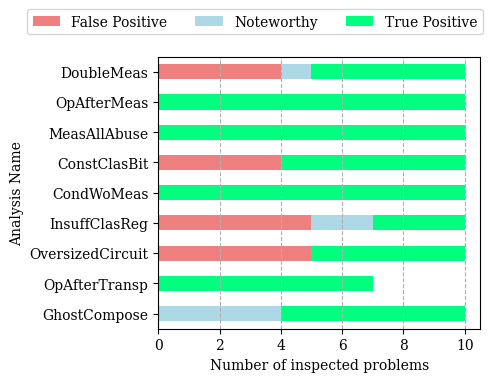

In [49]:
# # mark whatever is not agreed on as "FP"
# df_annotations[COL_AGREED_ANNOTATION] = df_annotations.apply(
#     lambda row: row["Annotator_1"] if row[COL_AGREEMENT_REACHED] else "FP", axis=1)

CONSIDERED_NW_IN_PRECISION = False

if df_annotations[COL_AGREED_ANNOTATION].nunique() == 3:
    COLORS = ["lightcoral", "lightblue", "springgreen"]  
else:
    COLORS = ["lightcoral", "springgreen"]
    
df_stacked_hist = df_annotations.copy() 
# keep COL_RULE, COL_AGREED_ANNOTATION columns
df_stacked_hist = df_stacked_hist[[COL_RULE, COL_AGREED_ANNOTATION, "message"]]
# count for each category
df_stacked_hist = df_stacked_hist.groupby(
    [COL_RULE, COL_AGREED_ANNOTATION]).count()

# rename message > count and reset index
df_stacked_hist = df_stacked_hist.rename(columns={"message": "count"})
df_stacked_hist = df_stacked_hist.reset_index(drop=False)
# convert rule_id in categorical and sort
df_stacked_hist[COL_RULE] = pd.Categorical(
    df_stacked_hist[COL_RULE], categories=list(RULE_NAME_MAPPING.keys()))
df_stacked_hist = df_stacked_hist.sort_values(COL_RULE, ascending=True)
# rename the rule_id with their mapping
df_stacked_hist[COL_RULE] = df_stacked_hist[COL_RULE].apply(
    lambda e: RULE_NAME_MAPPING[e] if e in RULE_NAME_MAPPING.keys() else e)

# put the different annotation categories as columns
df_pivoted = df_stacked_hist.pivot(
    index=COL_RULE, columns=COL_AGREED_ANNOTATION, values='count')
# rename categories
MAPPING_CATEGORY_NAMES = {
    "TP": "True Positive",
    "NW": "Noteworthy",
    "FP": "False Positive"
}
df_pivoted = df_pivoted.rename(columns=MAPPING_CATEGORY_NAMES)
# flip vertically
df_pivoted = df_pivoted.iloc[::-1]

fig, ax = plt.subplots(figsize=(5, 4))
df_pivoted.plot(
    kind='barh',
    stacked=True,
    color=COLORS,
    ax=ax 
)

# remove title from the legend
plt.legend(
    title=None,
    loc='upper center', bbox_to_anchor=(0.3, 1.2), ncol=3)

# add the labels
plt.xlabel("Number of inspected problems")
plt.ylabel(LINTQ_CHECKER_TERM + " Name")

# add vertical grid
plt.grid(axis='x', linestyle='--')

# STATS
if CONSIDERED_NW_IN_PRECISION:
    print(f"Considering noteworthy as TP")
    tp_labels = ["TP", "NW"]
else: 
    print(f"Considering noteworthy as FP")
    tp_labels = ["TP"]
average_precision = df_annotations.groupby(
    COL_RULE).apply(
        lambda df: (df[COL_AGREED_ANNOTATION].isin(tp_labels)).mean()).mean()
print(f"Average precision: {average_precision}")


plt.tight_layout()
fig.savefig(
    os.path.join(OUTPUT_FOLDER, "precision_estimate_abs.pdf"), 
    bbox_inches="tight")

In [50]:
df_precision_with_subannotations = df_pivoted.reset_index()
# fill na in all columns, excepts for rule_id
for col in df_precision_with_subannotations.columns:
    if col != COL_RULE:
        df_precision_with_subannotations[col] = df_precision_with_subannotations[col].fillna(0)
df_precision_with_subannotations


Resolution,rule_id,False Positive,Noteworthy,True Positive
0,GhostCompose,0.0,4.0,6.0
1,OpAfterTransp,0.0,0.0,7.0
2,OversizedCircuit,5.0,0.0,5.0
3,InsuffClasReg,5.0,2.0,3.0
4,CondWoMeas,0.0,0.0,10.0
5,ConstClasBit,4.0,0.0,6.0
6,MeasAllAbuse,0.0,0.0,10.0
7,OpAfterMeas,0.0,0.0,10.0
8,DoubleMeas,4.0,1.0,5.0


In [51]:
precision_series = df_annotations.groupby(
    COL_RULE).apply(
        lambda df: (df[COL_AGREED_ANNOTATION].isin(tp_labels)).mean())
df_precision_table = pd.DataFrame(precision_series).reset_index(drop=False)
# rename col 1 -> Precision
df_precision_table.rename(columns={0: "precision"}, inplace=True)
# rename rule_id with mapping
df_precision_table[COL_RULE] = df_precision_table[COL_RULE].apply( 
    lambda e: RULE_NAME_MAPPING[e] if e in RULE_NAME_MAPPING.keys() else e)

overall_precision = df_annotations[COL_AGREED_ANNOTATION].isin(tp_labels).mean()
print("\\newcommand{\\overallPrecisionLintQ}{" + f"{overall_precision * 100:.1f}" + "\%}")
median_precision = df_precision_table['precision'].median() * 100
print("\\newcommand{\\medianPrecisionLintQ}{" + f"{median_precision:.1f}" + "\%}")
mean_precision = df_precision_table['precision'].mean() * 100
print("\\newcommand{\\avgPrecisionLintQ}{" + f"{mean_precision:.1f}" + "\%}")
min_precision = df_precision_table['precision'].min() * 100
print("\\newcommand{\\minPrecisionLintQ}{" + f"{min_precision:.1f}" + "\%}")
max_precision = df_precision_table['precision'].max() * 100
print("\\newcommand{\\maxPrecisionLintQ}{" + f"{max_precision:.1f}" + "\%}")

df_annotations_best_checkers = df_annotations[
    ~df_annotations["rule_id"].isin(
        ["ql-unmeasurable-qubits", "ql-oversized-circuit"])]
overallPrecisionLintQBestCheckers = df_annotations_best_checkers[
    COL_AGREED_ANNOTATION].isin(tp_labels).mean()
print("\\newcommand{\\overallPrecisionLintQBestCheckers}{" + f"{overallPrecisionLintQBestCheckers * 100:.1f}" + "\%}")

# rename precision with Precision
df_precision_table.rename(columns={"precision": "Precision"}, inplace=True)
# format with %
df_precision_table["Precision"] = df_precision_table["Precision"].apply(
    lambda e: "{:.1f}%".format(e * 100))

# merge df_precision_table and df_warnings_table on the first column
df_precision_table_renamed = df_precision_table.rename(
    columns={COL_RULE: LINTQ_CHECKER_TERM + " Name"})
df_precision_warnings_table = df_warnings_table.merge(
    df_precision_table_renamed, on=LINTQ_CHECKER_TERM + " Name", how="left")

# merge with df_precision_with_subannotations
df_precision_with_subannotations_renamed = df_precision_with_subannotations.rename(
    columns={COL_RULE: LINTQ_CHECKER_TERM + " Name"})
df_precision_warnings_table = df_precision_warnings_table.merge(
    df_precision_with_subannotations_renamed, on=LINTQ_CHECKER_TERM + " Name", how="left")

# add progress bar: \dbTP{6}\dbNW{2}\dbFP{2}
# take values from the columns: False Positive	Noteworthy	True Positive
df_precision_warnings_table['FP / NW / TP'] = df_precision_warnings_table.apply(
    lambda row: "\\dbFP{" + f"{int(row['False Positive']):,}" + "}" + \
        "\\dbNW{" + f"{int(row['Noteworthy']):,}" + "}" + \
        "\\dbTP{" + f"{int(row['True Positive']):,}" + "}" + \
        " " + f"{int(row['False Positive']):,}" + \
        " / " + f"{int(row['Noteworthy']):,}" + \
        " / " + f"{int(row['True Positive']):,}",
        axis=1)
# drop those columns
df_precision_warnings_table = df_precision_warnings_table.drop(
    columns=["False Positive", "Noteworthy", "True Positive"])


# rename Files with warning -> % Files
# Precision -> Prec.
df_precision_warnings_table.rename(
    columns={
        "Files with warning": "% Files",
    }, inplace=True)

display(df_precision_warnings_table)

# export to latex
table = df_precision_warnings_table.to_latex(
    index=False, column_format="lp{2cm}p{1cm}p{1.5cm}l@{}")
# escape %
table = table.replace("%", "\\%")
print(table)


\newcommand{\overallPrecisionLintQ}{71.3\%}
\newcommand{\medianPrecisionLintQ}{60.0\%}
\newcommand{\avgPrecisionLintQ}{72.2\%}
\newcommand{\minPrecisionLintQ}{30.0\%}
\newcommand{\maxPrecisionLintQ}{100.0\%}
\newcommand{\overallPrecisionLintQBestCheckers}{80.6\%}


,Analysis Name,Tot. warnings,% Files,Precision,FP / NW / TP
0,DoubleMeas,39,0.36%,50.0%,\dbFP{4}\dbNW{1}\dbTP{5} 4 / 1 / 5
1,OpAfterMeas,127,0.92%,100.0%,\dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10
2,MeasAllAbuse,22,0.26%,100.0%,\dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10
3,ConstClasBit,533,4.29%,60.0%,\dbFP{4}\dbNW{0}\dbTP{6} 4 / 0 / 6
4,CondWoMeas,46,0.22%,100.0%,\dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10
5,InsuffClasReg,3489,17.35%,30.0%,\dbFP{5}\dbNW{2}\dbTP{3} 5 / 2 / 3
6,OversizedCircuit,378,3.01%,50.0%,\dbFP{5}\dbNW{0}\dbTP{5} 5 / 0 / 5
7,OpAfterTransp,7,0.05%,100.0%,\dbFP{0}\dbNW{0}\dbTP{7} 0 / 0 / 7
8,GhostCompose,12,0.09%,60.0%,\dbFP{0}\dbNW{4}\dbTP{6} 0 / 4 / 6


\begin{tabular}{lp{2cm}p{1cm}p{1.5cm}l@{}}
\toprule
Analysis Name & Tot. warnings & \% Files & Precision & FP / NW / TP \\
\midrule
DoubleMeas & 39 & 0.36\% & 50.0\% & \dbFP{4}\dbNW{1}\dbTP{5} 4 / 1 / 5 \\
OpAfterMeas & 127 & 0.92\% & 100.0\% & \dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10 \\
MeasAllAbuse & 22 & 0.26\% & 100.0\% & \dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10 \\
ConstClasBit & 533 & 4.29\% & 60.0\% & \dbFP{4}\dbNW{0}\dbTP{6} 4 / 0 / 6 \\
CondWoMeas & 46 & 0.22\% & 100.0\% & \dbFP{0}\dbNW{0}\dbTP{10} 0 / 0 / 10 \\
InsuffClasReg & 3489 & 17.35\% & 30.0\% & \dbFP{5}\dbNW{2}\dbTP{3} 5 / 2 / 3 \\
OversizedCircuit & 378 & 3.01\% & 50.0\% & \dbFP{5}\dbNW{0}\dbTP{5} 5 / 0 / 5 \\
OpAfterTransp & 7 & 0.05\% & 100.0\% & \dbFP{0}\dbNW{0}\dbTP{7} 0 / 0 / 7 \\
GhostCompose & 12 & 0.09\% & 60.0\% & \dbFP{0}\dbNW{4}\dbTP{6} 0 / 4 / 6 \\
\bottomrule
\end{tabular}



# RQ3: Complement Related Work

## QCheckers

In [52]:
FOLDER_WITH_QCHECKER_WARNINGS = "../data/datasets/exp_v08/qchecker"

RULE_NAME_MAPPING_QCHECKER = {
    "IG": "IncorrectUseGate",
    "MI": "MeasurementIssue",
    "IIS": "IncorrectInitState",
    "PE": "ParameterError",
    "CM": "CommandMisuse",
    "CE": "CallError",
    "QE": "QasmError",
    "DO": "DiscardedOrder"
}

# check how many files are in all the subfolders ending in "_error" 
error_folders = glob.glob(
    os.path.join(FOLDER_WITH_QCHECKER_WARNINGS, "*_errors"))
dict_error_per_rule_qchecker = {}
for folder_path in error_folders:
    folder_name = os.path.basename(folder_path)
    rule_name = folder_name.split("_")[0]
    n_files = len(os.listdir(folder_path))
    dict_error_per_rule_qchecker[rule_name] = n_files
print(dict_error_per_rule_qchecker)

# scan all the .sarif files and join them 
all_sarif_files = glob.glob(
    os.path.join(FOLDER_WITH_QCHECKER_WARNINGS, "*.sarif"))

df_results_qchecker = pd.concat([
    get_df_from_sarif(get_results_from_sarif_path(sarif_file))
    for sarif_file in all_sarif_files
])

# unique values rule_id
print(df_results_qchecker["rule_id"].unique())

# remove file:/// prefix
df_results_qchecker["file"] = df_results_qchecker["file"].apply(
    lambda e: e.replace("file:///", ""))

print(f"Total warnings: {len(df_results_qchecker)}")
display(df_results_qchecker.head())


compute_warnings_table(
    df_results=df_results_qchecker,
    rule_name_mapping=RULE_NAME_MAPPING_QCHECKER,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term="Rule"
)

{'DO': 4133, 'IM': 4133, 'CM': 4133, 'QE': 4133, 'CE': 4133, 'IIS': 4136, 'IG': 4133, 'MI': 4133, 'PE': 4133}
['DO' 'IG' 'IIS' 'PE' 'IM' 'QE' 'CE']
Total warnings: 1906


,rule_id,message,file,line,col
0,DO,"print(""Votre tâche (job) a l'identifiant à ret...",qiskit_job_execute_a1a942.py,35.0,1
1,DO,middle.iden(q),t1_f9bfa8.py,42.0,1
2,DO,print('Not all keys are identical. This sh...,task_2_4f46b2.py,60.0,1
3,DO,full_basis = np.identity(n),item3_weighted_ssvqe_2_824c3d.py,70.0,1
4,DO,"Hm = sum([pauli_x(i, -1) for i in range(n_qubi...",07_variational_circuits_qiskit_8df8ee.py,67.0,1


WARN: no warnings for rule MI. Adding a 0 value.
WARN: no warnings for rule CM. Adding a 0 value.
WARN: some rules are not in the mapping. Discarding them.
{'IM'}
\newcommand{\avgWarningsPerc}{2.94\%}
\newcommand{\medianWarningsPerc}{1.39\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
IncorrectUseGate & 155 & 2.05\% \\
MeasurementIssue & 0 & 0.00\% \\
IncorrectInitState & 641 & 8.47\% \\
ParameterError & 442 & 5.84\% \\
CommandMisuse & 0 & 0.00\% \\
CallError & 479 & 6.33\% \\
QasmError & 9 & 0.12\% \\
DiscardedOrder & 55 & 0.73\% \\
\bottomrule
\end{tabular}



,Rule Name,Tot. warnings,Files with warning
0,IncorrectUseGate,155,2.05%
1,MeasurementIssue,0,0.00%
2,IncorrectInitState,641,8.47%
3,ParameterError,442,5.84%
4,CommandMisuse,0,0.00%
5,CallError,479,6.33%
6,QasmError,9,0.12%
7,DiscardedOrder,55,0.73%


,Rule Name,Tot. warnings,Files with warning
2,IncorrectUseGate,155,2.05%
7,MeasurementIssue,0,0.00%
3,IncorrectInitState,641,8.47%
5,ParameterError,442,5.84%
8,CommandMisuse,0,0.00%
0,CallError,479,6.33%
6,QasmError,9,0.12%
1,DiscardedOrder,55,0.73%


## QSmell

In [53]:
FOLDER_WITH_QSMELL_WARNINGS = "../data/datasets/exp_v08/qsmell"

RULE_NAME_MAPPING_QSMELL = {
    'LPQ': 'LogicalPhysicalQubits',
    'NC': 'NonParameterizedCircuit',
}

# LOAD QSMELL WARNINGS
all_csv_files = [
    os.path.join(FOLDER_WITH_QSMELL_WARNINGS, f)
    for f in os.listdir(FOLDER_WITH_QSMELL_WARNINGS)
    if f.endswith(".csv")
]
df_results_qsmell = pd.concat([pd.read_csv(f) for f in all_csv_files])
df_results_qsmell.rename(columns={
    "metric": "rule_id", "filename": "file"
}, inplace=True)
# add default line column to 1
df_results_qsmell["line"] = 1
df_results_qsmell["col"] = 1


def derive_message(row):
    if row["value"] == "error":
        return "error"
    if int(row["value"]) >= 1:
        if row["rule_id"] == "NC":
            return f"{row['rule_id']} smell - " + \
                "Non-parameterized Circuit"
        if row["rule_id"] == "LPQ":
            return f"{row['rule_id']} smell - " + \
                "No-alignment between the Logical and Physical Qubits"
    return "no smell"

df_results_qsmell['message'] = df_results_qsmell.apply(derive_message, axis=1)

# count the errors per rule
dict_error_per_rule_qsmell = df_results_qsmell[
    df_results_qsmell["message"] == "error"
].groupby("rule_id").size().to_dict()
print(dict_error_per_rule_qsmell)

# drop errors
df_results_qsmell = df_results_qsmell[df_results_qsmell["message"] != "error"]
# drop no smells
df_results_qsmell = df_results_qsmell[df_results_qsmell["message"] != "no smell"]

# keep only rule_id, msg, file, line, col and drop remaining columns
df_results_qsmell = df_results_qsmell[
    ["rule_id", "message", "file", "line", "col"]]
display(df_results_qsmell.head())

print(f"Total warnings: {len(df_results_qsmell)}")

compute_warnings_table(
    df_results=df_results_qsmell,
    rule_name_mapping=RULE_NAME_MAPPING_QSMELL,
    total_files_in_dataset=TOTAL_FILES_IN_DATASET,
    rule_term="Rule"
)

{'LPQ': 21, 'NC': 21}


,rule_id,message,file,line,col
5,LPQ,LPQ smell - No-alignment between the Logical a...,unittest_7125fc.py,1,1
21,LPQ,LPQ smell - No-alignment between the Logical a...,4_c6ba6b.py,1,1
38,LPQ,LPQ smell - No-alignment between the Logical a...,test_4a62dd.py,1,1
41,LPQ,LPQ smell - No-alignment between the Logical a...,our_vqe_gjg_591c88.py,1,1
44,LPQ,LPQ smell - No-alignment between the Logical a...,alternating_operator_63165f.py,1,1


Total warnings: 2916
\newcommand{\avgWarningsPerc}{19.27\%}
\newcommand{\medianWarningsPerc}{19.27\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
LogicalPhysicalQubits & 698 & 9.22\% \\
NonParameterizedCircuit & 2218 & 29.31\% \\
\bottomrule
\end{tabular}



,Rule Name,Tot. warnings,Files with warning
0,LogicalPhysicalQubits,698,9.22%
1,NonParameterizedCircuit,2218,29.31%


,Rule Name,Tot. warnings,Files with warning
0,LogicalPhysicalQubits,698,9.22%
1,NonParameterizedCircuit,2218,29.31%


## Pylint

In [54]:
# print the list of only those files that have received TP from our annotation
TP_annotations_files = list(df_annotations[
    df_annotations[COL_AGREED_ANNOTATION] == "TP"
]["file"].unique())
print(
    "NOTE: add this field to the yaml config file of Pylint "
    "(e.g., pylint_vXX.yaml in the config folder)")
print("then run: python -m competitors.pylint.run_pylint_folder config/competitors/pylint_v08.yaml")
print("subset_files_to_analyze:")
for file in TP_annotations_files:
    print(f"  - {file}")

NOTE: add this field to the yaml config file of Pylint (e.g., pylint_vXX.yaml in the config folder)
then run: python -m competitors.pylint.run_pylint_folder config/competitors/pylint_v08.yaml
subset_files_to_analyze:
  - ahmed154_73ece9.py
  - test_sdk_352e8e.py
  - task_0f414b.py
  - test_circuit_qasm_ae5268.py
  - test_decompose_78559e.py
  - test_circuit_load_from_qasm_bf30ab.py
  - test_structure_aaba85.py
  - constante_1_00_d02e10.py
  - plot_histogram_083ab7.py
  - ex1_a7614b.py
  - new_guess_function_e73975.py
  - mgr_11_incrementer_as_instruction_6d53c5.py
  - fourier_transform_ncb_45a87d.py
  - qubitstates_903372.py
  - qrpgcg_cd84f9.py
  - test_qasm_simulator_edd048.py
  - quantum_e3f4e0.py
  - rsa_breaker_4_bit_0f27ff.py
  - h2evo_6bb46f.py
  - neoh2evo_28b965.py
  - test_mc_gate_13ba80.py
  - transpiled_stabilizer_test_7be7ce.py
  - example_1_c6d971.py
  - qrng_9498d5.py
  - bell_states_example_55fd07.py
  - polarization_20rotator_20angle_25374b.py
  - quantum_entanglement_

In [55]:
FOLDER_WITH_PYLINT_WARNINGS = "../data/datasets/exp_v08/pylint"

sarif_results_pylint = get_results_from_sarif_path(
    os.path.join(FOLDER_WITH_PYLINT_WARNINGS, "data.sarif"))
df_results_pylint = get_df_from_sarif(sarif_results_pylint)

# transform the file keeping only filename
df_results_pylint["file"] = df_results_pylint["file"].apply(
    lambda e: os.path.basename(e))
# convert line to int
df_results_pylint["line"] = df_results_pylint["line"].astype(int)

display(df_results_pylint.head())
print(f"Total warnings: {len(df_results_pylint)}")
    
compute_warnings_table(
    df_results=df_results_pylint,
    rule_name_mapping=None,
    total_files_in_dataset=len(TP_annotations_files),
    rule_term="Rule"
)

,rule_id,message,file,line,col
0,C0301,Line too long (112/100).,h2evo_6bb46f.py,17,1
1,C0301,Line too long (104/100).,h2evo_6bb46f.py,54,1
2,C0303,Trailing whitespace.,h2evo_6bb46f.py,55,97
3,C0114,Missing module docstring.,h2evo_6bb46f.py,1,1
4,C0413,"Import ""import numpy as np"" should be placed a...",h2evo_6bb46f.py,5,1


Total warnings: 2876
\newcommand{\avgWarningsPerc}{14.55\%}
\newcommand{\medianWarningsPerc}{5.66\%}
\begin{tabular}{lrr}
\toprule
Rule Name & Tot. warnings & Files with warning \\
\midrule
C0103 & 570 & 66.04\% \\
C0114 & 45 & 84.91\% \\
C0115 & 23 & 7.55\% \\
C0116 & 188 & 45.28\% \\
C0200 & 16 & 9.43\% \\
C0206 & 1 & 1.89\% \\
C0209 & 12 & 11.32\% \\
C0301 & 421 & 50.94\% \\
C0302 & 1 & 1.89\% \\
C0303 & 776 & 50.94\% \\
C0304 & 15 & 28.30\% \\
C0305 & 18 & 33.96\% \\
C0321 & 5 & 1.89\% \\
C0325 & 9 & 5.66\% \\
C0411 & 27 & 32.08\% \\
C0412 & 16 & 13.21\% \\
C0413 & 109 & 43.40\% \\
C1802 & 1 & 1.89\% \\
C1803 & 3 & 1.89\% \\
E0102 & 3 & 3.77\% \\
E0401 & 49 & 30.19\% \\
E0402 & 1 & 1.89\% \\
E0601 & 2 & 3.77\% \\
E0602 & 51 & 20.75\% \\
E0611 & 8 & 13.21\% \\
E1101 & 27 & 20.75\% \\
E1120 & 5 & 1.89\% \\
R0912 & 1 & 1.89\% \\
R0913 & 1 & 1.89\% \\
R0914 & 5 & 9.43\% \\
R0915 & 2 & 3.77\% \\
R0916 & 1 & 1.89\% \\
R1705 & 6 & 3.77\% \\
R1710 & 4 & 5.66\% \\
R1714 & 4 & 5.66\% \\
R172

,Rule Name,Tot. warnings,Files with warning
0,C0103,570,66.04%
1,C0114,45,84.91%
2,C0115,23,7.55%
3,C0116,188,45.28%
4,C0200,16,9.43%
5,C0206,1,1.89%
6,C0209,12,11.32%
7,C0301,421,50.94%
8,C0302,1,1.89%
9,C0303,776,50.94%


,Rule Name,Tot. warnings,Files with warning
0,C0103,570,66.04%
1,C0114,45,84.91%
2,C0115,23,7.55%
3,C0116,188,45.28%
4,C0200,16,9.43%
5,C0206,1,1.89%
6,C0209,12,11.32%
7,C0301,421,50.94%
8,C0302,1,1.89%
9,C0303,776,50.94%


## Compute Overlap on TP

In [56]:
df_lintq_tp  = df_annotations[df_annotations[COL_AGREED_ANNOTATION] == "TP"]

relevant_files_w_tp = df_lintq_tp["file"].unique()
n_relevant_files_w_tp = len(relevant_files_w_tp)

# check the intersection between these files and lines and the dataset
# of qsmell and qchecker
df_lintq_tp = df_lintq_tp[["rule_id", "file", "line"]]
# convert line to int
df_lintq_tp["line"] = df_lintq_tp["line"].astype(int)

COMPETITORS = [
    {"name": "QChecker", "df": df_results_qchecker},
    {"name": "QSmell", "df": df_results_qsmell},
    {"name": "Pylint", "df": df_results_pylint}
]
display(df_lintq_tp.head())
latex_commands = ""
for competitor in COMPETITORS:
    name = competitor["name"]
    df = competitor["df"]

    df_on_relevant_files = df[df["file"].isin(relevant_files_w_tp)]
    print(f"Total {name} warnings: {len(df_on_relevant_files)}")
    latex_commands += "\\newcommand{\\nWarningsOnLintQTPwith" + name + "}{" + f"{len(df_on_relevant_files)}" + "}\n"
    n_files_flagged_by_competitor = len(df_on_relevant_files["file"].unique())
    flag_ratio = n_files_flagged_by_competitor / n_relevant_files_w_tp
    perc_flag_ratio = flag_ratio * 100
    print(f"Ratio of {name} warnings on relevant files: {flag_ratio}")
    # latex_commands += "\\newcommand{\\percRatio" + name + "OnTP}{" + f"{perc_flag_ratio:.1f}" + "\\%}\n"

    print(f"Checking {name}")
    # convert line to int
    df["line"] = df["line"].astype(int)
    df = df[["rule_id", "file", "line", "message"]]
    # merge
    df_competitor_pointing_to_lintq_lines = df_lintq_tp.merge(
        df,
        how="inner",
        on=["file", "line"],
        suffixes=("_lintq", f"_{name}"),
    )
    # count
    overlap_size = len(df_competitor_pointing_to_lintq_lines)
    print(f"Overlapping {name}: {overlap_size}")
    latex_commands += "\\newcommand{\\nWarningsOnLintQTPwith" + name + "Overlap}{" + f"{overlap_size}" + "}\n"
    display(df_competitor_pointing_to_lintq_lines.head(30))

n_lintq_tp = len(df_lintq_tp)
print(f"Total TP: {n_lintq_tp}")
latex_commands += "\\newcommand{\\nLintqTP}{" + f"{n_lintq_tp}" + "}\n"

print("-" * 80)
print("Latex")
print(latex_commands)



,rule_id,file,line
0,ql-conditional-without-measurement,ahmed154_73ece9.py,11
1,ql-conditional-without-measurement,test_sdk_352e8e.py,34
2,ql-conditional-without-measurement,task_0f414b.py,38
3,ql-conditional-without-measurement,task_0f414b.py,39
4,ql-conditional-without-measurement,task_0f414b.py,47


Total QChecker warnings: 35
Ratio of QChecker warnings on relevant files: 0.49056603773584906
Checking QChecker
Overlapping QChecker: 2


,rule_id_lintq,file,line,rule_id_QChecker,message
0,ql-double-measurement,qubitstates_903372.py,12,IIS,"qc.measure(0, 1)"
1,ql-op-after-optimization,source_59a0eb956a0d4e6b8720f272136f2799_9b8ba7.py,34,IIS,"qc.measure(qr, cr)"


Total QSmell warnings: 30
Ratio of QSmell warnings on relevant files: 0.5471698113207547
Checking QSmell
Overlapping QSmell: 0


,rule_id_lintq,file,line,rule_id_QSmell,message


Total Pylint warnings: 2876
Ratio of Pylint warnings on relevant files: 1.0
Checking Pylint
Overlapping Pylint: 9


,rule_id_lintq,file,line,rule_id_Pylint,message
0,ql-constant-classic-bit,ex1_a7614b.py,66,C0103,"Variable name ""qc"" doesn't conform to snake_ca..."
1,ql-constant-classic-bit,mgr_11_incrementer_as_instruction_6d53c5.py,166,C0103,"Variable name ""qc"" doesn't conform to snake_ca..."
2,ql-double-measurement,rsa_breaker_4_bit_0f27ff.py,137,C0303,Trailing whitespace.
3,ql-ghost-composition,transpiled_stabilizer_test_7be7ce.py,413,E1120,No value for argument 'other' in method call.
4,ql-operation-after-measurement,quantumteleportation_2823d6.py,16,W0311,"Bad indentation. Found 1 spaces, expected 4."
5,ql-oversized-circuit,a03_deutsch_algorithm_solutions_checkpoint_cd1...,129,W0621,Redefining name 'circuit' from outer scope (li...
6,ql-unmeasurable-qubits,test_u_gate_940648.py,43,C0103,"Variable name ""qc"" doesn't conform to snake_ca..."
7,ql-unmeasurable-qubits,test_structure_aaba85.py,1,C0302,Too many lines in module (1562/1000).
8,ql-unmeasurable-qubits,test_structure_aaba85.py,1,C0114,Missing module docstring.


Total TP: 62
--------------------------------------------------------------------------------
Latex
\newcommand{\nWarningsOnLintQTPwithQChecker}{35}
\newcommand{\nWarningsOnLintQTPwithQCheckerOverlap}{2}
\newcommand{\nWarningsOnLintQTPwithQSmell}{30}
\newcommand{\nWarningsOnLintQTPwithQSmellOverlap}{0}
\newcommand{\nWarningsOnLintQTPwithPylint}{2876}
\newcommand{\nWarningsOnLintQTPwithPylintOverlap}{9}
\newcommand{\nLintqTP}{62}



# RQ2: Modeling Info: Abstractions and Queries
- How many CodeQL LoC per checker. 
- Avg number of abstractions used. >> bipartite graph.


In [57]:
def read_files(folder: str, extension: str = ".ql") -> Dict[str, str]:
    """Read all files with the given extension in the folder and subfolders."""
    ql_files = {}
    for file in glob.glob(folder + f'/**/*{extension}', recursive=True):
        with open(file, 'r') as f:
            content = f.read()
            ql_files[file.replace(folder, "")] = content
    return ql_files

def get_abstractions_used(content: str) -> List[str]:
    """Get the abstractions used in the given content."""
    abstractions = []
    for line in content.splitlines():
        if line.startswith('import'):
            abstraction = line.split(' ')[1]
            abstractions.append(abstraction)
    return abstractions

In [58]:
query_files = read_files(
    folder=DETECTORS_FOLDER, extension='.ql')
abstraction_files = read_files(
    folder=ABSTRACTION_FOLDER, extension='.qll')

print(f'Number of queries: {len(query_files)}')
print(f'Number of abstractions: {len(abstraction_files)}')
all_query_names = list(query_files.keys())
print(all_query_names)

all_abstractions_names = list(abstraction_files.keys())
print(all_abstractions_names)

Number of queries: 22
Number of abstractions: 13
['/Backend/InitWithoutTranspilation.ql', '/Backend/MeasWithStatevector.ql', '/Measurement/SuperfluousOp.ql', '/Measurement/OpAfterMeasurement.ql', '/Measurement/MeasureAll.ql', '/Measurement/DoubleMeasurement.ql', '/Measurement/ConditionalGateWithoutMeas.ql', '/Measurement/OpAfterMeasurementGeneral.ql', '/Qsmell/NoAlignmentLogicalPhysical.ql', '/Qsmell/NonParametrizedCircuit.ql', '/Resource/OversizedCircuit.ql', '/Resource/ConstantClassicBit.ql', '/Resource/UnmeasurableQubits.ql', '/Simulation/InvalidPauliSyntaxError.ql', '/Simulation/InvalidPauliErrorSize.ql', '/Vulnerability/TokenLeakage.ql', '/Metrics/CircuitSize.ql', '/Interconnection/IncompatibleComposition.ql', '/Interconnection/UngovernedComposition.ql', '/Interconnection/GhostFromQasm.ql', '/Interconnection/GhostComposition.ql', '/Optimization/OpAfterOptimization.ql']
['/Register.qll', '/BitDef.qll', '/SensitiveAPI.qll', '/Qubit.qll', '/Pauli.qll', '/Backend.qll', '/QuantumOperat

### RQ1.A Which abstractions are used in the different queries?

In [59]:
def get_abstractions_from_qll(content: str) -> List[str]:
    """Get the abstractions used in the given content.
    
    It uses regex."""
    # get: class TestClass()
    classes = re.findall(r'^class (\w+)', content, re.MULTILINE)
    return classes

def get_predicates_from_qql(content: str) -> List[str]:
    """Get the predicates used in the given content.
    
    It uses regex."""
    # get also: predicate testPredicate(
    predicates = re.findall(r'^predicate (\w+)', content, re.MULTILINE)
    return predicates

all_abstraction_defined = []
for abstraction_file in abstraction_files.values():
    all_abstraction_defined += get_abstractions_from_qll(abstraction_file)
    all_abstraction_defined += get_predicates_from_qql(abstraction_file)

print(f'Number of abstractions defined: {len(all_abstraction_defined)}')
print(all_abstraction_defined)

Number of abstractions defined: 104
['QuantumRegisterV2', 'ClassicalRegisterV2', 'ImplicitCircuitQubitDefinition', 'ImplicitCircuitClbitDefinition', 'ImplicitRegisterQubitDefinition', 'ImplicitRegisterClbitDefinition', 'ExplicitSingleQubitDefinition', 'ExplicitSingleClbitDefinition', 'isIntegerParameterOfCall', 'IBMCloudTokenSink', 'PauliString', 'Backend', 'BackendRunViaRunCall', 'BackendRunViaExecuteCall', 'BackendResult', 'Statevector', 'PauliError', 'EmptySetForString', 'EmptySetForInt', 'EmptySetForRegisterV2', 'EmptySetForQuantumCircuit', 'QubitUseViaAttribute', 'QubitUseViaAppend', 'QubitUseViaMeasureAll', 'OperatorSpecificationAttributeName', 'OperatorSpecificationObjectName', 'OperatorSpecificationReset', 'OperatorSpecificationMeasureAll', 'OperatorSpecificationMeasure', 'OperatorSpecificationInitialize', 'OperatorSpecificationUnitaryGateObj', 'OperatorSpecificationUnitaryCall', 'OperatorSpecificationSingleQubitNoParam', 'OperatorSpecificationPGate', 'OperatorSpecificationRXGa

In [60]:
def check_abstractions_used(abstraction: List[str], content: str) -> bool:
    """Check if the given abstraction is used in the content.
    
    Via regex.
    """
    abstractions_used = []
    for a in abstraction:
        if re.search(rf'\b{a}\b', content):
            abstractions_used.append(a)
    return abstractions_used

def get_color_for_abstr_family(
        df: pd.DataFrame,
        col_name: str,
        format_str: str = 'hex',):
    """Get a color dict mapping each abstraction to a color.
    
    Nota that this mapping is based on the abstraciton name.
    If not specified it is grey.
    """
    # create thematic groups for source
    if format_str == 'hex':
        color_themes = {
            "pauli": "#dc267f",
            # purple
            "compos": "#785ef0",
            "transp": "#785ef0",
            # resources
            "insuf": "#fe6100", 
            "oversize": "#fe6100",
            # yellow
            "[^u]?meas": "#ffb001",
            "[^u]?const": "#ffb001",       
        }
    elif format_str == 'rgb':
        color_themes = {
            "pauli": "rgb(220, 38, 127)",
            "compos": "rgb(120, 94, 240)",
            "insuf": "rgb(254, 97, 0)", 
            "oversize": "rgb(254, 97, 0)",
            "[^u]?meas": "rgb(255, 176, 1)",    
        }
    per_family_color = {}
    for row in df.iterrows():
        query_name = row[1][col_name]
        # default
        per_family_color[query_name] = "grey"
        for k in color_themes.keys():
            if re.search(k, query_name.lower()):
                per_family_color[query_name] = color_themes[k]
                break
    return per_family_color

query_to_abstraction = {}

for query_name, query_content in query_files.items():
    abstractions_used = check_abstractions_used(
        abstraction=all_abstraction_defined, 
        content=query_content)
    if abstractions_used:
        base_name = os.path.basename(query_name)
        if base_name in FILE_NAME_RULE_MAPPING:
            base_name = FILE_NAME_RULE_MAPPING[base_name]
        query_to_abstraction[base_name] = abstractions_used
        print(f'{query_name}: {abstractions_used}')

/Backend/InitWithoutTranspilation.ql: ['Backend', 'QuantumCircuit', 'TranspiledCircuit', 'Gate']
/Backend/MeasWithStatevector.ql: ['Backend', 'BackendRunViaRunCall', 'Statevector', 'QuantumCircuit', 'TranspiledCircuit', 'Gate']
/Measurement/SuperfluousOp.ql: ['Backend', 'SubCircuit', 'QuantumCircuitConstructor', 'QuantumCircuit', 'mayFollow', 'Gate']
/Measurement/OpAfterMeasurement.ql: ['mayFollow', 'mayFollowDirectly', 'sortedInOrder', 'Gate']
/Measurement/MeasureAll.ql: ['QuantumCircuit', 'MeasurementAll']
/Measurement/DoubleMeasurement.ql: ['mayFollowDirectly', 'Gate']
/Measurement/ConditionalGateWithoutMeas.ql: ['SubCircuit', 'Gate']
/Measurement/OpAfterMeasurementGeneral.ql: ['mayFollow', 'sortedInOrder', 'Gate']
/Qsmell/NonParametrizedCircuit.ql: ['QuantumCircuit']
/Resource/OversizedCircuit.ql: ['QuantumRegisterV2', 'SubCircuit', 'QuantumCircuitConstructor', 'QuantumCircuit', 'TranspiledCircuit']
/Resource/ConstantClassicBit.ql: ['SubCircuit', 'QuantumCircuitConstructor', 'Quant

,source,target,type,value
0,InitWithoutTranspilation.ql,Backend,use,1
1,InitWithoutTranspilation.ql,QuantumCircuit,use,1
2,InitWithoutTranspilation.ql,TranspiledCircuit,use,1
3,InitWithoutTranspilation.ql,Gate,use,1
4,MeasWithStatevector.ql,Backend,use,1


\newcommand{\avgAbstractionsUsedPerQuery}{3.1}
\newcommand{\avgQueriesSupportedPerAbstraction}{4.2}
Number of null values: 31
Number of null values: 0
['DoubleMeas', 'OpAfterMeas', 'MeasAllAbuse', 'ConstClasBit', 'CondWoMeas', 'InsuffClasReg', 'OversizedCircuit', 'OpAfterTransp', 'GhostCompose']


/tmp/ipykernel_20106/1113701964.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  use_relationship_per_query = df_abstractions.groupby('source').count()['value']


,source,target,type,value
56,GhostCompose,SubcircuitComposition,use,1
55,GhostCompose,SubcircuitComposition,use,1
57,OpAfterTransp,TranspiledCircuit,use,1
58,OpAfterTransp,Gate,use,1
34,OversizedCircuit,TranspiledCircuit,use,1
31,OversizedCircuit,SubcircuitComposition,use,1
33,OversizedCircuit,QuantumCircuit,use,1
32,OversizedCircuit,QuantumCircuit,use,1
30,OversizedCircuit,Register,use,1
43,InsuffClasReg,Measurement,use,1


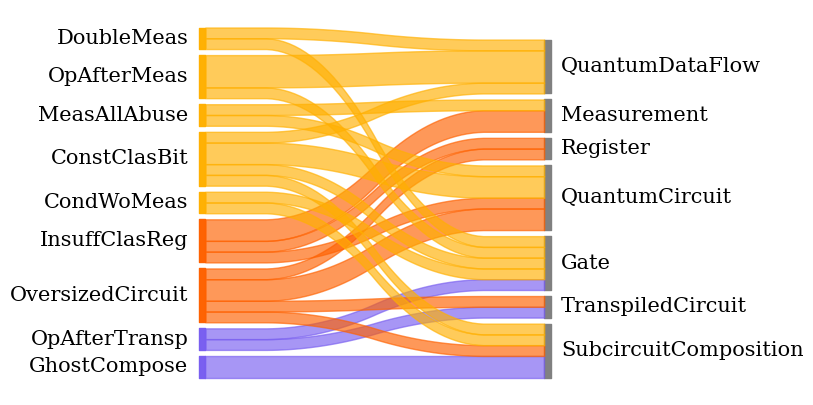

In [61]:
FAMILY_NAME_SUBCIRC = 'SubcircuitComposition'
FAMILY_NAME_QDF = "QuantumDataFlow"
FAMILY_NAME_MEAS = "Measurement"
FAMILY_NAME_QC = "QuantumCircuit"
ABSTRACTION_MAPPING = {
    "MeasureGateCall": FAMILY_NAME_MEAS,
    "MeasurementAll": FAMILY_NAME_MEAS,
    "mayFollow": FAMILY_NAME_QDF,
    "mayFollowDirectly": FAMILY_NAME_QDF,
    "sortedInOrder": FAMILY_NAME_QDF,
    "ComposeCall": FAMILY_NAME_SUBCIRC,
    "ReturnsNewValue": FAMILY_NAME_SUBCIRC,
    "SubCircuit": FAMILY_NAME_SUBCIRC,
    "QuantumRegisterV2": "Register",
    "QuantumCircuit": FAMILY_NAME_QC,
    "QuantumCircuitConstructor": FAMILY_NAME_QC
}

# # get matplotlib rc configuration
# rc = plt.rcParams.copy()

from pySankey.sankey import sankey
# source,target,type,value

records = []
for query_name, abstractions in query_to_abstraction.items():
    for abstraction in abstractions:
        records.append({
            'source': query_name,
            'target': abstraction,
            'type': 'use',
            'value': 1,
        })
df_abstractions = pd.DataFrame.from_records(records)
# map abstraction names
df_abstractions['target'] = df_abstractions['target'].apply(
    lambda e: ABSTRACTION_MAPPING[e] if e in ABSTRACTION_MAPPING else e)

display(df_abstractions.head())
# sort by canonical order
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=list(set(NAME_MAPPING.values()))
)
df_abstractions = df_abstractions.sort_values('source', ascending=False)
df_abstractions.head()
# compute the average number of records per source 
use_relationship_per_query = df_abstractions.groupby('source').count()['value']
#print(use_relationship_per_query)
avg_use_relationship_per_query = use_relationship_per_query.mean()
print("\\newcommand{\\avgAbstractionsUsedPerQuery}{" + f"{avg_use_relationship_per_query:.1f}" + "}")
avg_use_relationship_per_abstraction = df_abstractions.groupby('target').count()['value'].mean()
print("\\newcommand{\\avgQueriesSupportedPerAbstraction}{" + f"{avg_use_relationship_per_abstraction:.1f}" + "}")


# check null values, print and drop them 
print(f"Number of null values: {df_abstractions.isnull().sum().sum()}")
df_abstractions = df_abstractions.dropna()
print(f"Number of null values: {df_abstractions.isnull().sum().sum()}")

per_family_color = get_color_for_abstr_family(
    df=df_abstractions,
    col_name='source',
)

# colorDict: yellow for target and blue for source
colorDict = {
    #**{k: 'slateblue' for k in df_abstractions['source'].unique()}, 
    **per_family_color,
    **{k: 'gray' for k in df_abstractions['target'].unique()}
}

# sort by canonical order
canonical_order = list(RULE_NAME_MAPPING.values())
print(canonical_order)
df_abstractions['source'] = pd.Categorical(
    df_abstractions['source'],
    categories=canonical_order)
df_abstractions = df_abstractions.sort_values('source', ascending=False)

display(df_abstractions)
sankey(
    left=df_abstractions['source'],
    right=df_abstractions['target'],
    aspect=20,
    colorDict=colorDict,
    fontsize=15,
)
plt.gcf().set_size_inches(5, 5)
plt.savefig(
    os.path.join(OUTPUT_FOLDER, 'sankey_abstraction_v2.pdf'),
    bbox_inches='tight')

# go back to the initial rc configuration
# plt.rcParams.update(rc)

9
\newcommand{\avgLoCQuery}{11.4}
\newcommand{\minLoCQuery}{7}
\newcommand{\maxLoCQuery}{17}


/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/paltenmo/.conda/envs/LintQEnv/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


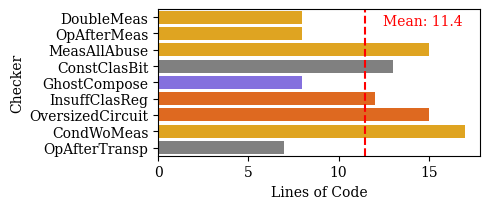

In [10]:
SHOW_QUERIES_DEBUG = False

records = []
for query_name, query_content in query_files.items():
    # count the lines in the content excluding the imports and the comment lines
    # comment start with: /* or * or //
    # imports start with: import
    lines = query_content.splitlines()
    lines = [
        line for line in lines
        # use regex to ensure we account for spaces
        if not re.match(r'^\s*import', line) and
        not re.match(r'^\s*//', line) and
        not re.match(r'^\s*\*', line) and
        not re.match(r'^\s*/\*', line)  
    ]
    # remove empty lines
    lines = [l for l in lines if l != '']
    loc = len(lines)
    if SHOW_QUERIES_DEBUG:
        print("\n".join(lines))
        print(query_name, loc)
        # check that none of the line is longer than 80 chars
        for line in lines:
            if len(line) > 80:
                print("___________________ line too long: ", line)
    base_query_name = os.path.basename(query_name)
    # keep only if it is in the mapping (aka relevant queries)
    if base_query_name in FILE_NAME_RULE_MAPPING:
        records.append({
            'query_name': FILE_NAME_RULE_MAPPING[base_query_name],
            'loc': loc
        })

df_loc_queries = pd.DataFrame.from_records(records)
print(len(df_loc_queries))
# sort by canonical order
categories = [
    cat for cat in RULE_NAME_MAPPING.values()
    if "QSmell" not in cat
]
df_loc_queries['query_name'] = pd.Categorical(
    df_loc_queries['query_name'], categories=categories)
df_loc_queries = df_loc_queries.sort_values('query_name')

per_family_color = get_color_for_abstr_family(
    df=df_loc_queries,
    col_name='query_name',
)

# plot the lines of code histogram
fig, ax = plt.subplots(figsize=(5, 2.2))
sns.barplot(
    data=df_loc_queries,
    y='query_name',
    x='loc',
    palette=per_family_color.values(),
    # sort
    #order=df_loc_queries.sort_values('loc', ascending=True)['query_name'],
)
ax.set_xlabel('Lines of Code')
ax.set_ylabel('Checker')
mean_value = df_loc_queries['loc'].mean()
# add red line for the mean
ax.axvline(mean_value, color='red', linestyle='--')
# plot the label of the mean
ax.text(
    mean_value + 1,
    0.5,
    f'Mean: {mean_value:.1f}',
    color='red',
)
plt.tight_layout()
fig.savefig(
    os.path.join(OUTPUT_FOLDER, 'loc_queries.pdf')
)
print("\\newcommand{\\avgLoCQuery}{" + f"{mean_value:.1f}" + "}")
min_value = df_loc_queries['loc'].min()
print("\\newcommand{\\minLoCQuery}{" + f"{min_value:.0f}" + "}")
max_value = df_loc_queries['loc'].max()
print("\\newcommand{\\maxLoCQuery}{" + f"{max_value:.0f}" + "}")

# RQ5: Efficiency

In [42]:

# READ LOG DATA
log_content = open(LOG_FILE_QUERIES, 'r').read()
log_content_db = open(LOG_FILE_DB_CREATION, 'r').read()

# modules in 4447.50s
for db_log_line in log_content_db.splitlines():
    if " modules in " in db_log_line:
        #print(db_log_line)
        total_time_db = float(re.findall(r'modules in (\d+\.?\d+?)s', db_log_line)[0])


# a line looks like this
# [1/14 comp 9.1s] Compiled /home/.../codeql/src/Interconnection/GhostComposition.ql.
# parse the time and the file name
lines = log_content.splitlines()
compilation_lines = [l for l in lines if "Compiled" in l]
compilation_times = {
    re.findall(r'([a-zA-Z]+)\.ql\.$', l)[0] : float(re.findall(r'(\d+\.?\d?)s', l)[0])
    for l in compilation_lines
}
evaluation_lines = [l for l in lines if "Evaluation done" in l]
evaluation_times = {}
for l in evaluation_lines:
    key =  re.findall(r'([a-zA-Z]+)\.bqrs\.$', l)[0]
    seconds = float(re.findall(r'(\d+\.?\d?)s', l)[0])
    if minutes_regex := re.findall(r'(\d+\.?\d?)m', l):
        seconds += float(minutes_regex[0]) * 60
    evaluation_times[key] = seconds
evaluation_times

# create a dataframe with the compilation and evaluation times
df_times = pd.DataFrame.from_dict(
    {
        'compilation_time': compilation_times,
        'evaluation_time': evaluation_times
    }
)
df_times.reset_index(inplace=True)
df_times.rename(columns={'index': 'detector_rule'}, inplace=True)

# remove blacklisted detectors
RELEVANT_QUERY = [name.replace(".ql", "") for name in FILE_NAME_RULE_MAPPING.keys()]
df_times = df_times[
    df_times['detector_rule'].isin(RELEVANT_QUERY)]
df_times.reset_index(drop=True, inplace=True)
# sort by canonical order
df_times['detector_rule'] = pd.Categorical(
    df_times['detector_rule'], categories=RELEVANT_QUERY)
df_times = df_times.sort_values('detector_rule')

avg_comp_time = df_times['compilation_time'].mean()
avg_exec_time = df_times['evaluation_time'].mean()
print("\\newcommand{\\avgPerDetectorQueryCompilationTimeSec}{" + f"{avg_comp_time:.1f}" + "}")
print("\\newcommand{\\avgPerDetectorEvaluationTimeSec}{" + f"{avg_exec_time:.1f}" + "}")

total_comp_time = df_times['compilation_time'].sum()
total_exec_time = df_times['evaluation_time'].sum()
total_exec_time_min = total_exec_time / 60
print("\\newcommand{\\totalDatasetQueryCompilationTimeSec}{" + f"{total_comp_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeSec}{" + f"{total_exec_time:.1f}" + "}")
print("\\newcommand{\\totalDatasetEvaluationTimeMin}{" + f"{total_exec_time_min:.0f}" + "}")


total_time_db_min = total_time_db / 60
print("\\newcommand{\\totalDatasetCreationTimeSec}{" + f"{total_time_db:.1f}" + "}")
print("\\newcommand{\\totalDatasetCreationTimeMin}{" + f"{total_time_db_min:.0f}" + "}")

normalized_time_per_query = total_exec_time / TOTAL_FILES_IN_DATASET
print("\\newcommand{\\avgPerProgramEvaluationTimeSec}{" + f"{normalized_time_per_query:.1f}" + "}")

display(df_times)

# get the top three detector rules per evaluation time
df = df_times.copy()
df.sort_values(by='evaluation_time', ascending=False, inplace=True)
df = df.head(3)
number_prefixes = ['One', 'Two', 'Three']
i = 0
for _, row in df.iterrows():
    name = row['detector_rule']
    time = row['evaluation_time']
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "}{" + name + "}")
    print("\\newcommand{\\topThreeDetectorRule" + str(number_prefixes[i]) + "TimeSec}{" + f"{time:.1f}" + "}")
    i += 1


\newcommand{\avgPerDetectorQueryCompilationTimeSec}{6.3}
\newcommand{\avgPerDetectorEvaluationTimeSec}{1032.1}
\newcommand{\totalDatasetQueryCompilationTimeSec}{57.0}
\newcommand{\totalDatasetEvaluationTimeSec}{9289.0}
\newcommand{\totalDatasetEvaluationTimeMin}{155}
\newcommand{\totalDatasetCreationTimeSec}{4447.5}
\newcommand{\totalDatasetCreationTimeMin}{74}
\newcommand{\avgPerProgramEvaluationTimeSec}{1.2}


,detector_rule,compilation_time,evaluation_time
1,DoubleMeasurement,5.9,2554.0
2,OpAfterMeasurement,6.1,2066.0
4,MeasureAll,6.3,174.0
7,ConstantClassicBit,5.4,1510.0
0,GhostComposition,5.4,174.0
8,UnmeasurableQubits,5.3,138.0
6,OversizedCircuit,5.1,1226.0
5,ConditionalGateWithoutMeas,11.7,1226.0
3,OpAfterOptimization,5.8,221.0


\newcommand{\topThreeDetectorRuleOne}{DoubleMeasurement}
\newcommand{\topThreeDetectorRuleOneTimeSec}{2554.0}
\newcommand{\topThreeDetectorRuleTwo}{OpAfterMeasurement}
\newcommand{\topThreeDetectorRuleTwoTimeSec}{2066.0}
\newcommand{\topThreeDetectorRuleThree}{ConstantClassicBit}
\newcommand{\topThreeDetectorRuleThreeTimeSec}{1510.0}


In [39]:
[name.replace(".ql", "") for name in FILE_NAME_RULE_MAPPING.keys()]

['DoubleMeasurement',
 'OpAfterMeasurement',
 'MeasureAll',
 'ConstantClassicBit',
 'GhostComposition',
 'UnmeasurableQubits',
 'OversizedCircuit',
 'ConditionalGateWithoutMeas',
 'OpAfterOptimization']

# RQ6: Recall

In [49]:
PATH_BUGS4Q_ANNOTATION_LINTQ = "../data/analysis_results/Bugs4Q-Framework_08_08_2023/codeql_2023-09-20_13-47-05/01_Annotation_bugs4q.csv"
COL_AGREED_ANNOTATION = "Annotator_1"
COL_RULE = "rule_id"
TOTAL_FILES_IN_BUGS4Q = 42

df_annotations_bugs4q = pd.read_csv(PATH_BUGS4Q_ANNOTATION_LINTQ)
n_warnings_bugs4q = len(df_annotations_bugs4q)
print("\\newcommand{\\nWarningsBugsFourQ}{" + f"{n_warnings_bugs4q}" + "}")

n_TP_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "TP"])
print("\\newcommand{\\nTPBugsFourQ}{" + f"{n_TP_bugs4q}" + "}")

n_FP_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "FP"])
print("\\newcommand{\\nFPBugsFourQ}{" + f"{n_FP_bugs4q}" + "}")

n_NW_bugs4q = len(df_annotations_bugs4q[
    df_annotations_bugs4q[COL_AGREED_ANNOTATION] == "NW"])
print("\\newcommand{\\nNWBugsFourQ}{" + f"{n_NW_bugs4q}" + "}")

# precision per rule_id
df_annotations_bugs4q['rule_id'].unique()
df_annotations_bugs4q['rule_id'].value_counts()

# compute precision per rule
dict_precision_per_rule = {}
for rule_id in df_annotations_bugs4q['rule_id'].unique():
    df_rule = df_annotations_bugs4q[df_annotations_bugs4q['rule_id'] == rule_id]
    n_TP = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "TP"])
    n_FP = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "FP"])
    n_NW = len(df_rule[df_rule[COL_AGREED_ANNOTATION] == "NW"])
    precision = n_TP / (n_TP + n_FP + n_NW)
    dict_precision_per_rule[rule_id] = precision
    print("\\newcommand{\\precRule" + rule_id.replace("-", "") + "BugsFourQ}{" + f"{precision*100:.1f}\\%" + "}")

# number of files where is_bug_for_bugs4q is true 
n_buggy_files_detected = len(df_annotations_bugs4q[
    df_annotations_bugs4q['is_bug_for_bugs4q'] == True]['Location'].unique())
print("\\newcommand{\\nBuggyFilesDetectedBugsFourQ}{" + f"{n_buggy_files_detected}" + "}")

recall = n_buggy_files_detected / TOTAL_FILES_IN_BUGS4Q
print("\\newcommand{\\recallBugsFourQ}{" + f"{recall*100:.1f}\\%" + "}")




\newcommand{\nWarningsBugsFourQ}{30}
\newcommand{\nTPBugsFourQ}{8}
\newcommand{\nFPBugsFourQ}{18}
\newcommand{\nNWBugsFourQ}{4}
\newcommand{\precRuleqlconstantclassicbitBugsFourQ}{100.0\%}
\newcommand{\precRuleqlmeasureallabuseBugsFourQ}{100.0\%}
\newcommand{\precRuleqloperationaftermeasurementBugsFourQ}{100.0\%}
\newcommand{\precRuleqloversizedcircuitBugsFourQ}{66.7\%}
\newcommand{\precRuleqlunmeasurablequbitsBugsFourQ}{0.0\%}
\newcommand{\nBuggyFilesDetectedBugsFourQ}{2}
\newcommand{\recallBugsFourQ}{4.8\%}


# RQ2: Real Bugs

In [95]:
df_real_bugs_reported = pd.read_csv(PATH_REAL_BUGS)
# keep only those reported by last version of detectors
present_col_name = [
    c for c in df_real_bugs_reported.columns if "Present_in" in c][0]
df_real_bugs_reported = df_real_bugs_reported[
    df_real_bugs_reported[present_col_name] == "yes"
]
# map longer output -> Long. Out.
df_real_bugs_reported["manifestation"] = df_real_bugs_reported["manifestation"].apply(
    lambda x: "LongOut" if x == "Longer output" else x
)
# map rule_id 
df_real_bugs_reported["rule_id"] = df_real_bugs_reported["rule_id"].apply(
    lambda x: RULE_NAME_MAPPING[x] if x in RULE_NAME_MAPPING else x
)
# mapt the status
# Reported -> Report.
# Confirmed -> Confir
# Fixed -> Fix
mapping_status = {
    "Reported": "Report",
    "Confirmed": "Confirm",
    "Fixed": 'Fixed'
}
df_real_bugs_reported["status"] = df_real_bugs_reported["status"].apply(
    lambda x: mapping_status[x] if x in mapping_status else x
)

print(df_real_bugs_reported.columns)
mapping_numbers = {
    "1": "One",
    "2": "Two",
    "3": "Thr",
    "4": "Fou",
    "5": "Fiv",
    "6": "Six",
    "7": "Sev",
    "8": "Eig",
    "9": "Nin",
    "0": "Zer",
}

df_real_bugs_reported = df_real_bugs_reported.reset_index(drop=False)
df_real_bugs_reported.rename(columns={"index": "ID"}, inplace=True)
for i, row in df_real_bugs_reported.iterrows():
    msg = row["issue"]
    # remove underscores
    msg = msg.replace("_", "")
    for k, v in mapping_numbers.items():
        msg = msg.replace(k, v)
    # msg = msg.translate(str.maketrans('', '', string.punctuation))
    # msg = ''.join([w.capitalize() for w in msg.lower().split()])
    # msg = ''.join(ch for ch in msg if ch.isalpha())
    if msg != "":
        print("\\newcommand{\\ID" + msg + "}{" + str(row["ID"]) + "}")

# Keep only relevant columns columns
df_real_bugs_reported = df_real_bugs_reported[
    ["ID", "rule_id", "description", "status", "manifestation", "issue"]
]

# convert issue number in apex
df_real_bugs_reported["issue"] = df_real_bugs_reported["issue"].apply(
    lambda x: "$^{" + x+ "}$" if x != "" else x
)

# rename columns
# rule_id > Analysis Name
# description > Description
# status -> Status
# manifestation -> Manif.
df_real_bugs_reported.rename(
    columns={
        "rule_id": LINTQ_CHECKER_TERM + " Name",
        "description": "Description",
        "status": "Status",
        "manifestation": "Manif.",
        "issue": "Issue"
    }, inplace=True
)


display(df_real_bugs_reported)

# export to latex
table = df_real_bugs_reported.to_latex(
    index=False, column_format="p{0.1cm}p{2cm}p{6.2cm}p{0.8cm}p{0.8cm}p{1.4cm}")
# escape %
table = table.replace("%", "\\%")
table = table.replace("_", "\_")

print(table)


Index(['issue', 'rule_id', 'description', 'file', 'line',
       'Present_in_codeql_2023-09-18_17-17-54', 'status', 'manifestation'],
      dtype='object')
\newcommand{\IDZerEigcFivZerSevThrFouFouOneTwo}{0}
\newcommand{\IDZerSixfeSixZerZerNinSixThr}{1}
\newcommand{\IDZerSixOneThrbaEigZerNinZer}{2}
\newcommand{\IDZerSixOneThrbaEigZerOneZerSev}{3}
\newcommand{\IDZerSixFoucNinFouFouThrThrFiv}{4}
\newcommand{\IDZerEigcFoucThrFoufFivNin}{6}
\newcommand{\IDZerEigNinTwoThrTwoeaFivFiv}{7}
\newcommand{\IDZerSixFivFivfdZerSevTwoFiv}{8}
\newcommand{\IDZerSixSevafThrThrTwoThrFiv}{9}
\newcommand{\IDZerSixZerNinbeZerThrOneNin}{10}
\newcommand{\IDZerSixdfSixZerEigfThrTwoTwo}{11}


,ID,Analysis Name,Description,Status,Manif.,Issue
0,0,MeasAllAbuse,Measure all generates a twice as long output,Confirm,Silent,$^{08_c50734_412}$
1,1,DoubleMeas,Redundant measurment,Fixed,Silent,$^{06_fe6009_63}$
2,2,GhostCompose,Missing compose assignment in a test case,Fixed,Silent,$^{06_13ba80_90}$
3,3,GhostCompose,Missing compose assignment in a test case,Fixed,Silent,$^{06_13ba80_107}$
4,4,InsuffClasReg,Unused qubit,Report,Silent,$^{06_4c9443_35}$
5,6,OpAfterTransp,Measure gate added to a transpiled circuit,Report,Silent,$^{08_c4c34f_59}$
6,7,OpAfterTransp,Grover algo: measure gate added after transp.,Report,Silent,$^{08_9232ea_55}$
7,8,MeasAllAbuse,Measure all $\rightarrow$ twice as long output...,Report,LongOut,$^{06_55fd07_25}$
8,9,MeasAllAbuse,Measure all $\rightarrow$ twice as long output...,Report,LongOut,$^{06_7af332_35}$
9,10,MeasAllAbuse,Measure all $\rightarrow$ twice as long output,Report,LongOut,$^{06_09be03_19}$


\begin{tabular}{p{0.1cm}p{2cm}p{6.2cm}p{0.8cm}p{0.8cm}p{1.4cm}}
\toprule
ID & Analysis Name & Description & Status & Manif. & Issue \\
\midrule
0 & MeasAllAbuse & Measure all generates a twice as long output & Confirm & Silent & $^{08\_c50734\_412}$ \\
1 & DoubleMeas & Redundant measurment & Fixed & Silent & $^{06\_fe6009\_63}$ \\
2 & GhostCompose & Missing compose assignment in a test case & Fixed & Silent & $^{06\_13ba80\_90}$ \\
3 & GhostCompose & Missing compose assignment in a test case & Fixed & Silent & $^{06\_13ba80\_107}$ \\
4 & InsuffClasReg & Unused qubit & Report & Silent & $^{06\_4c9443\_35}$ \\
6 & OpAfterTransp & Measure gate added to a transpiled circuit & Report & Silent & $^{08\_c4c34f\_59}$ \\
7 & OpAfterTransp & Grover algo: measure gate added after transp. & Report & Silent & $^{08\_9232ea\_55}$ \\
8 & MeasAllAbuse & Measure all $\rightarrow$ twice as long output (Bell pair) & Report & LongOut & $^{06\_55fd07\_25}$ \\
9 & MeasAllAbuse & Measure all $\rightarrow$ tw